# **BIOF 509 Final Project - Autism Spectrum Disorder (ASD) and Gut Microbiome**

Importing the required packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import umap #make sure to install umap with: "pip install umap-learn"
import matplotlib.pyplot as plt
import seaborn as sns

Defining functions to be used in the analysis

In [2]:
def normalizer(df):
    '''
    a function to min-max normalize all the columns of a dataframe for each column
    df: a dataframe with patients as columns and microbiota species as rows
    '''
    normalized_df = (df - df.min()) / (df.max() - df.min())
    return(normalized_df)

In [3]:
def PCA_Plotter(df, status):
    '''
    a function to call the PCA function from sklearn, fit and transform the transposed data,
    and display the scree plot with the PCA scatterplot
    df: a dataframe with patients as rows and microbiota as columns (features)
    status: a binary status of patient ASD status: 1 for ASD positive, 0 for ASD negative
    '''
    pca = PCA()
    pca.fit(df)
    pca_data = pca.transform(df)
    
    percent_var = np.round(pca.explained_variance_ratio_*100, decimals=2)
    top10_var = percent_var[0:10]
    labels = np.array(['PC' + str(x) for x in range(1, len(percent_var)+1)]) #zero indexed for range()
    labels_top10 = labels[0:10]
    scree_df = pd.DataFrame({'Principal Component':labels_top10, 'Percent Variance':top10_var})
    pca_df = pd.DataFrame(pca_data, index=status, columns=labels)
    
    plt.style.use('fivethirtyeight')
    sns.set_style('white')
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(17, 8))
    ax1.bar(data=scree_df, x='Principal Component', height='Percent Variance')
    ax1.set_xlabel('Principal Component', fontsize=16)
    ax1.set_ylabel('Percent Variance (%)', fontsize=16)
    ax1.set_title('Scree Plot', fontsize=22)
    ax2 = sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue=pca_df.index, s=100)
    ax2.set_xlabel('PC1 - {}%'.format(percent_var[0]), fontsize=16)
    ax2.set_ylabel('PC2 - {}%'.format(percent_var[1]), fontsize=16)
    ax2.set_title('Principal Component Analysis', fontsize=22)
    plt.show()

In [4]:
def UMAPer(df, status):
    '''
    a function to make a UMAP dimensionality reduction scatterplot
    df: a dataframe with patients as rows and microbiota as columns (features)
    status: a binary status of patient ASD status: 1 for ASD positive, 0 for ASD negative
    '''
    reducer = umap.UMAP()
    reduction_points = reducer.fit_transform(df)
    reduction_df = pd.DataFrame(reduction_points, index=status, columns=['UMAP_1', 'UMAP_2'])
    
    plt.style.use('fivethirtyeight')
    sns.set_style('white')
    fig, ax = plt.subplots(figsize=(5.5,5.5))
    ax = sns.scatterplot(data=reduction_df, x='UMAP_1', y='UMAP_2', hue=reduction_df.index)
    ax.set_title('UMAP Scatterplot')
    plt.show()

## Importing the Data and Preprocessing

Setting the filepath and importing the ASD meta abundance and 16s rRNA datasets

In [5]:
filepath = "/home/reach/Documents/BIOF 509 - Machine Learning/Final Project"
meta_abundance = pd.read_csv(filepath+"/ASD meta abundance.csv")
rRNA = pd.read_csv(filepath+"/GSE113690_Autism_16S_rRNA_OTU_assignment_and_abundance.csv")
print('Shape of meta_abundance dataset is: {}'.format(meta_abundance.shape))
print('Shape of 16s rRNA dataset is: {}'.format(rRNA.shape))

Shape of meta_abundance dataset is: (5619, 61)
Shape of 16s rRNA dataset is: (1322, 256)


Filtering out lowly abundant microbiota, Min-Max Normalizing for each patient (column) and then transposing the dataframe so that each microbe taxa is a feature (column) and each patient is a row

In [6]:
# Meta abundance dataset
meta_abundance.set_index('Taxonomy', inplace=True)
meta_filt = meta_abundance[meta_abundance.mean(axis=1)>1]  #filter step

meta_abundance_norm = normalizer(meta_filt) #normalization step
taxa = meta_abundance_norm.index
ma_t = meta_abundance_norm.transpose() #transposing step

print('shape of filtered, normalized, and transposed meta_abandance is: {}'.format(ma_t.shape))

shape of filtered, normalized, and transposed meta_abandance is: (60, 1456)


In [7]:
# 16s rRNA dataset 
rRNA_tax = rRNA.drop('OTU', axis=1).set_index('taxonomy')
rRNA_filt = rRNA_tax[rRNA_tax.mean(axis=1)>1] #filter step
rRNA_taxa = rRNA_filt.index

rRNA_tax_norm = normalizer(rRNA_filt) #normalization step
rRNA_t = rRNA_tax_norm.transpose() #transposing step

print('shape of filtered, normalized, and transposed 16s rRNA is: {}'.format(rRNA_t.shape))

shape of filtered, normalized, and transposed 16s rRNA is: (254, 445)


Making Autism status binary

In [8]:
meta_asd_status = np.array([1 if patient.startswith('A') else 0 for patient in ma_t.index])
display(meta_asd_status)

rRNA_asd_status = np.array([1 if patient.startswith('A') else 0 for patient in rRNA_t.index])
display(rRNA_asd_status)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Running PCA and UMAP on the meta abundance and 16s rRNA datasets based on ASD status

Running PCA First

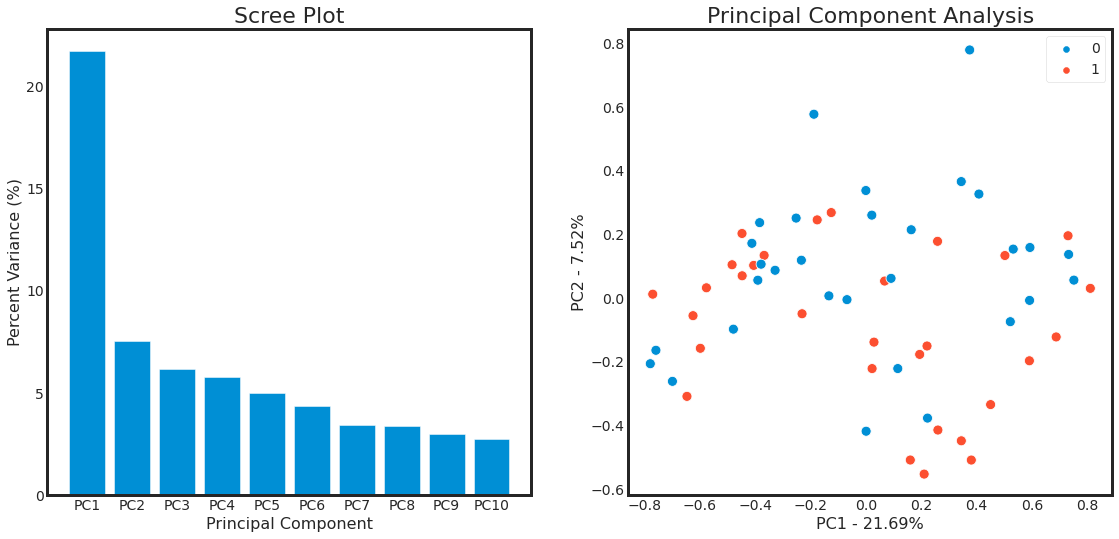

In [9]:
# PCA for the meta abundance data 
%matplotlib inline
PCA_Plotter(df=ma_t, status=meta_asd_status)

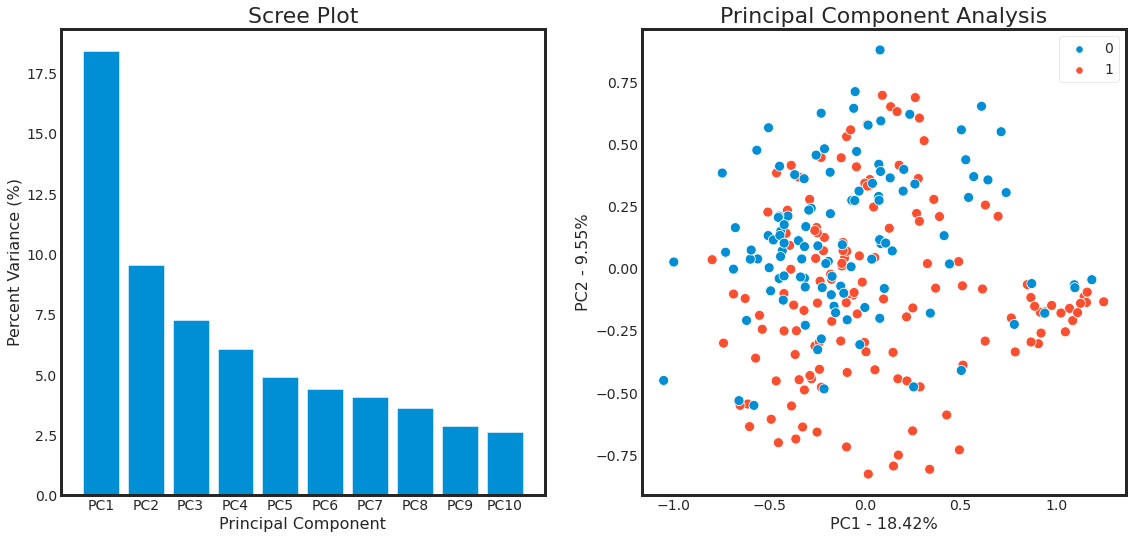

In [10]:
# PCA for the 16s rRNA data
PCA_Plotter(df=rRNA_t, status=rRNA_asd_status)

Running UMAP Next

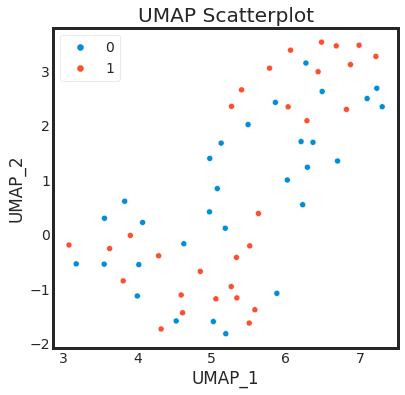

In [11]:
# UMAP on the metabundance data
UMAPer(df=ma_t, status=meta_asd_status)

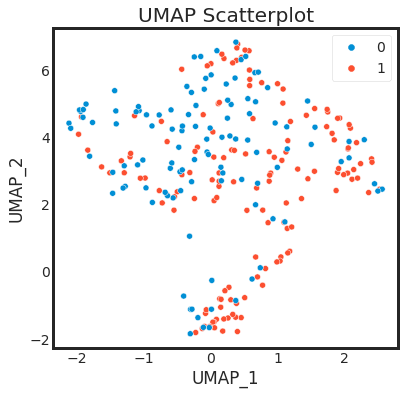

In [12]:
# UMAP on the 16s rRNA data 
UMAPer(df=rRNA_t, status=rRNA_asd_status)

## Running Supervised Machine Learning Algorithms with K Fold Cross Validation

In [13]:
# Supervised Machine Learning Algorithms 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [14]:
# K fold cross validation 
#from sklearn.model_selection import StratifiedKFold  #tried this and it didn't work
from sklearn.model_selection import cross_val_score

In [15]:
def ML_tester(model, df, key, fold):
    '''
    A function to test a supervised machine learning algorithm (model) on a given dataset (df)
    based on the binary keys (key) of the datasets.  Specify fold, which gives the fold for 
    K fold cross validation (recommended fold = 10).
    Returns a pandas dataframe with the scores of the test model included
    '''
    score = cross_val_score(model, df, key, cv=fold)
    ml_df = pd.DataFrame({'Model': str(model), 'Scores': score})
    return(score, ml_df)

## Running supervised learning algorithms on the meta abundance dataset first 

We can choose from LogisticRegression(), SVC(), and RandomForestClassifier() for our 
supervised learning models

In [54]:
# Logistic Regression
lr_scores, lr_df = ML_tester(model=LogisticRegression(), df=ma_t, key=meta_asd_status, fold=10)

In [55]:
# SVM
svm_scores, svm_df = ML_tester(model=SVC(), df=ma_t, key=meta_asd_status, fold=10)

In [57]:
# Testing different tree numbers for Random Forest 
trees = [3, 6, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for tree in trees:
    scores, df = ML_tester(model=RandomForestClassifier(n_estimators=tree), df=ma_t, key=meta_asd_status, fold=10)
    print("Average scores for {}".format(tree), "trees are", np.mean(scores))

Average scores for 3 trees are 0.7166666666666668
Average scores for 6 trees are 0.7
Average scores for 10 trees are 0.7333333333333334
Average scores for 20 trees are 0.7666666666666667
Average scores for 30 trees are 0.8
Average scores for 40 trees are 0.7666666666666667
Average scores for 50 trees are 0.8
Average scores for 60 trees are 0.7833333333333333
Average scores for 70 trees are 0.7833333333333333
Average scores for 80 trees are 0.7333333333333334
Average scores for 90 trees are 0.7666666666666667
Average scores for 100 trees are 0.8


In [58]:
# Random Forest with 30 trees - it looks like 30 tress is good enough
rf_scores, rf_df = ML_tester(model=RandomForestClassifier(n_estimators=30), df=ma_t, key=meta_asd_status, fold=10)

In [59]:
# Merging all machine learning score dataframes for graphing 
score_df = pd.concat([lr_df, svm_df, rf_df], axis=0, ignore_index=True)
models = {'LogisticRegression()': 'Logistic Regression', 'SVC()': 'SVM', 'RandomForestClassifier(n_estimators=30)': 'Random Forest'}
score_df = score_df.replace({'Model': models})
display(score_df.groupby('Model').mean())

,Scores
Model,
Logistic Regression,0.65
Random Forest,0.75
SVM,0.65


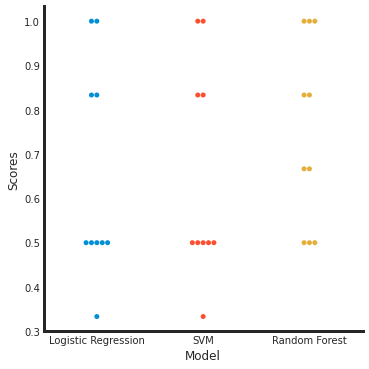

In [61]:
# Plotting the 10 fold cross validation results for the 3 machine learning models used
%matplotlib inline
sns.set_style('white')
sns.catplot(data=score_df, x='Model', y='Scores', kind='swarm')

## Running supervised learning algorithms on the 16s rRNA dataset next

We can choose from LogisticRegression(), SVC(), and RandomForestClassifier() for our 
supervised learning models

In [62]:
# Logistic Regression
lr_scores, lr_df = ML_tester(model=LogisticRegression(), df=rRNA_t, key=rRNA_asd_status, fold=10)

In [63]:
# SVM
svm_scores, svm_df = ML_tester(model=SVC(), df=rRNA_t, key=rRNA_asd_status, fold=10)

In [64]:
# Testing different tree numbers for Random Forest 
trees = [3, 6, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for tree in trees:
    scores, df = ML_tester(model=RandomForestClassifier(n_estimators=tree), df=rRNA_t, key=rRNA_asd_status, fold=10)
    print("Average scores for {}".format(tree), "trees are", np.mean(scores))

Average scores for 3 trees are 0.7544615384615384
Average scores for 6 trees are 0.7595384615384615
Average scores for 10 trees are 0.8013846153846155
Average scores for 20 trees are 0.8416923076923076
Average scores for 30 trees are 0.8576923076923076
Average scores for 40 trees are 0.8650769230769232
Average scores for 50 trees are 0.8652307692307692
Average scores for 60 trees are 0.857076923076923
Average scores for 70 trees are 0.868923076923077
Average scores for 80 trees are 0.8849230769230768
Average scores for 90 trees are 0.8689230769230768
Average scores for 100 trees are 0.8769230769230768


In [65]:
# Random Forest with 30 trees - it looks like 30 tress is good enough
rf_scores, rf_df = ML_tester(model=RandomForestClassifier(n_estimators=30), df=rRNA_t, key=rRNA_asd_status, fold=10)

In [66]:
# Merging all machine learning score dataframes for graphing 
score_df = pd.concat([lr_df, svm_df, rf_df], axis=0, ignore_index=True)
models = {'LogisticRegression()': 'Logistic Regression', 'SVC()': 'SVM', 'RandomForestClassifier(n_estimators=30)': 'Random Forest'}
score_df = score_df.replace({'Model': models})
display(score_df.groupby('Model').mean())

,Scores
Model,
Logistic Regression,0.656769
Random Forest,0.889077
SVM,0.664308


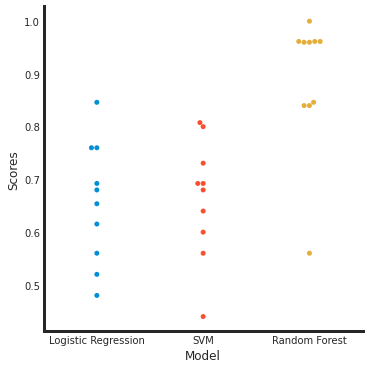

In [68]:
# Plotting the 10 fold cross validation results for the 3 machine learning models used
%matplotlib inline
sns.set_style('white')
sns.catplot(data=score_df, x='Model', y='Scores', kind='swarm')

# **End of Project :)**